In [ ]:
# Install PyTorch
!pip install -U torch==1.8.1+cu101 torchvision==0.9.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# Install MMCV
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html

In [ ]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
from mmseg.datasets import build_dataset
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
from mmseg.apis import set_random_seed, train_segmentor
from mmseg.models import build_segmentor
print(mmseg.__version__)

import mmcv
from mmcv import Config

import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

1.8.1+cu101 True
0.20.2


In [2]:
!rm -rf segmentation
!unzip segmentationV3.zip

Archive:  segmentationV3.zip
   creating: segmentation/
   creating: segmentation/annotations/
  inflating: segmentation/annotations/image005-roi4.jpg  
  inflating: segmentation/annotations/image021-roi4.jpg  
  inflating: segmentation/annotations/image021-roi5.jpg  
  inflating: segmentation/annotations/image006-2-roi3.jpg  
  inflating: segmentation/annotations/image058-roi4.jpg  
  inflating: segmentation/annotations/image005-2-roi3.jpg  
  inflating: segmentation/annotations/image006-roi5.jpg  
  inflating: segmentation/annotations/image058-roi5.jpg  
  inflating: segmentation/annotations/image032-roi1.jpg  
  inflating: segmentation/annotations/image024-roi4.jpg  
  inflating: segmentation/annotations/image058-roi7.jpg  
  inflating: segmentation/annotations/image005-roi3.jpg  
  inflating: segmentation/annotations/image023-roi3.jpg  
  inflating: segmentation/annotations/image062-roi2.jpg  
  inflating: segmentation/annotations/image020-roi3.jpg  
  inflating: segmentation/annot

In [3]:
data_root = 'segmentation'
img_dir = 'images'
ann_dir = 'annotations'

In [4]:
classes = ('bg', 'cell')
palette = [[0, 0, 0], [255, 255, 255]]

In [5]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.jpg')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
    # select first 4/5 as train set
    train_length = int(len(filename_list)*4/5)
    f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
    # select last 1/5 as train set
    f.writelines(line + '\n' for line in filename_list[train_length:])

In [6]:
@DATASETS.register_module()
class TestDatest(CustomDataset):
    CLASSES = classes
    PALETTE = palette
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.jpg', seg_map_suffix='.jpg', split=split, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None

In [7]:
cfg = Config.fromfile('segmentation_files/UnetTest.py')

In [8]:
cfg.dataset_type = 'TestDatest'

cfg.data.train.type = cfg.dataset_type
cfg.data.train.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.split = 'splits/val.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.split = 'splits/val.txt'

In [9]:
datasets = [build_dataset(cfg.data.train)]

/home/neto/anaconda3/envs/torch_gpu/lib/python3.9/site-packages/mmcv/utils/misc.py:333: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  warnings.warn(
2022-01-11 20:51:25,875 - mmseg - INFO - Loaded 24 images


In [10]:
model = build_segmentor(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES

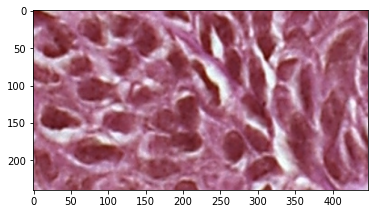

In [11]:
img = datasets[0].__getitem__(0)['img']
plt.imshow(img.data.cpu().permute(1, 2, 0).numpy())

In [12]:
img.data.cpu().numpy().shape

(3, 240, 448)

In [13]:
model

EncoderDecoder(
  (backbone): UNet(
    (encoder): ModuleList(
      (0): Sequential(
        (0): BasicConvBlock(
          (convs): Sequential(
            (0): ConvModule(
              (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): SyncBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (activate): ReLU(inplace=True)
            )
            (1): ConvModule(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): SyncBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (activate): ReLU(inplace=True)
            )
          )
        )
      )
      (1): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): BasicConvBlock(
          (convs): Sequential(
            (0): ConvModule(
              (conv): Conv2d(64, 128, kernel_

In [14]:
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

In [30]:
datasets[0].__getitem__(1)['img_metas']

DataContainer({'filename': 'segmentation/images/image037-roi4.jpg', 'ori_filename': 'image037-roi4.jpg', 'ori_shape': (250, 450, 3), 'img_shape': (213, 384, 3), 'pad_shape': (213, 384, 3), 'scale_factor': array([0.85333335, 0.852     , 0.85333335, 0.852     ], dtype=float32), 'flip': False, 'flip_direction': 'horizontal', 'img_norm_cfg': {'mean': array([0., 0., 0.], dtype=float32), 'std': array([1., 1., 1.], dtype=float32), 'to_rgb': False}})

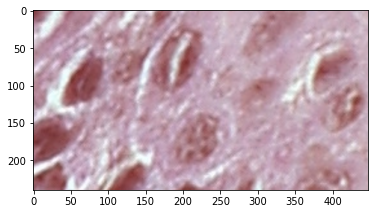

In [31]:
item = datasets[0].__getitem__(1)
img = item['img']
seg = item['gt_semantic_seg']
plt.imshow(img.data.cpu().permute(1, 2, 0).numpy())

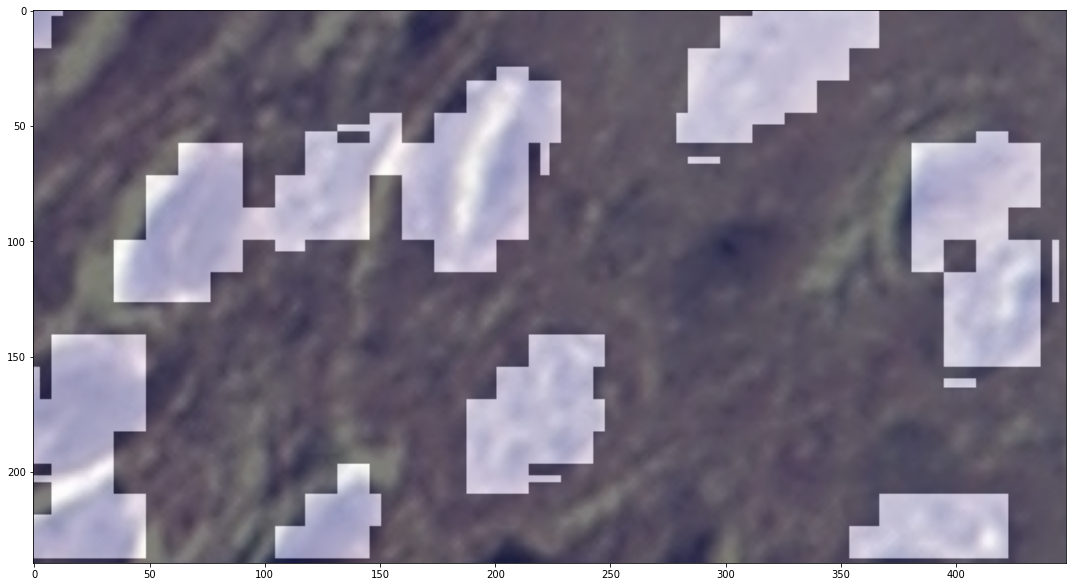

In [32]:
from mmseg.apis import show_result_pyplot
show_result_pyplot(model, img.data.cpu().permute(1,2,0).numpy(), seg.data.cpu().numpy(), palette)

In [24]:
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

2022-01-11 20:56:41,471 - mmseg - INFO - Loaded 24 images
2022-01-11 20:56:41,471 - mmseg - INFO - Start running, host: neto@Matheus-Neto, work_dir: /home/neto/projects/tcc/work_dirs/tutorial
2022-01-11 20:56:41,472 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
 -------------------- 
after_train_iter:
(ABOVE_NORMAL) Optimi

RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [18]:
seg.data.cpu().numpy()

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])

In [19]:
for label, color in enumerate(palette):
  print(label, color)

0 [0, 0, 0]
1 [255, 255, 255]
